In [1]:
# %load withholding.py
%matplotlib notebook
import matplotlib as plt
import numpy as np
import pandas as pd

df = pd.read_csv("../../data/withholding.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    rcompute = compute / np.sum(compute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / row.number_activations
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    d = {}
    d["attacker_compute"] = rcompute[0]
    d["attacker_relative_activations"] = ractivations[0]
    d["attacker_relative_reward"] = rreward[0]
    d["attacker_gain"] = rreward[0] - ractivations[0]
    d["attacker_efficiency"] = rreward[0] / ractivations[0]
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

In [2]:
df.columns

Index(['network', 'network_description', 'compute', 'protocol', 'k',
       'protocol_description', 'block_interval', 'activation_delay',
       'number_activations', 'activations', 'incentive_scheme',
       'incentive_scheme_description', 'strategy', 'strategy_description',
       'reward', 'machine_duration_s', 'error', 'attacker_compute',
       'attacker_relative_activations', 'attacker_relative_reward',
       'attacker_gain', 'attacker_efficiency'],
      dtype='object')

In [6]:
df[df.protocol != "nakamoto"].pivot(
    index=["attacker_compute", "k"],
    columns=["protocol", "strategy", "incentive_scheme"],
    values="attacker_efficiency",
)

protocol                       bk+ll                                          \
strategy             private-selfish           private-selfish-alt             
incentive_scheme            constant     block            constant     block   
attacker_compute k                                                             
0.10             1          0.348516  0.348516            0.348516  0.348516   
                 2          0.236134  0.217116            0.236910  0.217590   
                 4          0.168753  0.264746            0.168155  0.264691   
                 8          0.148084  0.374736            0.141989  0.364292   
                 16         0.158330  0.605210            0.157268  0.602768   
                 32         0.214143  1.153964            0.210311  1.131993   
                 64         0.337994  2.337669            0.329215  2.284725   
                 128        0.584969  4.744778            0.578987  4.689936   
0.20             1          0.629780  0.629780            0.629780  0.629780   
                 2          0.510298  0.450556            0.512492  0.453178   
                 4          0.432548  0.599045            0.429152  0.592997   
                 8          0.455508  0.941935            0.455961  0.939445   
                 16         0.570020  1.615946            0.572520  1.617820   
                 32         0.807208  2.844840            0.801701  2.837713   
                 64         1.091931  4.280437            1.085392  4.274493   
                 128        1.234161  4.966779            1.232531  4.970384   
0.25             1          0.749398  0.749398            0.749398  0.749398   
                 2          0.649052  0.570321            0.649052  0.570321   
                 4          0.585620  0.774994            0.585266  0.771531   
                 8          0.643676  1.222870            0.643014  1.225628   
                 16         0.831091  2.064067            0.827254  2.058568   
                 32         1.101615  3.195007            1.100598  3.186956   
                 64         1.290052  3.917361            1.289175  3.917794   
                 128        1.321968  4.005187            1.322894  3.999344   
0.33             1          0.920815  0.920815            0.920822  0.920822   
                 2          0.862516  0.760749            0.864702  0.763164   
                 4          0.839803  1.036581            0.844449  1.043284   
                 8          0.971261  1.611198            0.975119  1.614118   
                 16         1.219095  2.413249            1.224339  2.419155   
                 32         1.423087  2.955726            1.419966  2.962342   
                 64         1.467834  3.033816            1.469742  3.025634   
                 128        1.480573  3.031102            1.481919  3.024904   
0.40             1          1.059157  1.059157            1.059157  1.059157   
                 2          1.037272  0.927045            1.037247  0.927036   
                 4          1.086553  1.268502            1.080403  1.260671   
                 8          1.276292  1.838802            1.274550  1.840177   
                 16         1.513539  2.373073            1.514575  2.370007   
                 32         1.613399  2.497858            1.613379  2.497366   
                 64         1.640358  2.500331            1.640371  2.500338   
                 128        1.655483  2.495085            1.652709  2.501601   
0.45             1          1.150336  1.150336            1.150336  1.150336   
                 2          1.149563  1.041995            1.148067  1.040749   
                 4          1.265886  1.418382            1.268120  1.419500   
                 8          1.496498  1.913164            1.495649  1.915138   
                 16         1.695824  2.192373            1.693363  2.199521   
                 32         1.762280  2.220737            1.759831  2.224427   


<IPython.core.display.Javascript object>


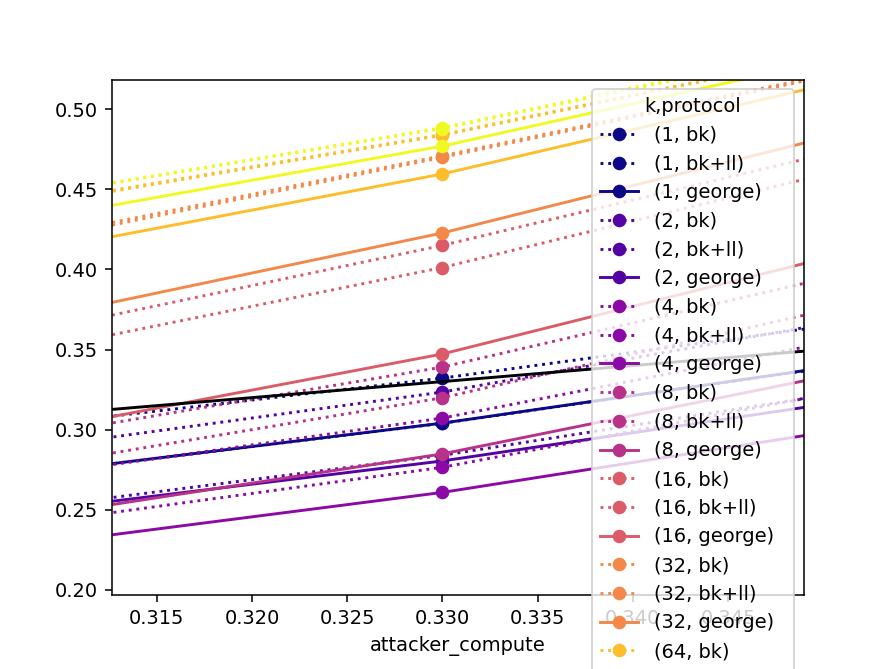

In [14]:
# compare same strategy for different protocols
d = df
d = d[d["strategy"] == "private-selfish"]
d = d[d.incentive_scheme == "constant"]
d = d.pivot(
    index=["attacker_compute"],
    columns=["k", "protocol"],
    values="attacker_relative_reward",
)
d = d[sorted(d.columns)]
line_style = ["o-" if proto == "george" else "o:" for (k, proto) in d.columns]
k = np.unique([k for (k, proto) in d.columns])
cmap = plt.cm.get_cmap("plasma", len(k))
colormap = {k: cmap(i) for (i, k) in enumerate(k)}
line_colors = [colormap[k] for (k, proto) in d.columns]
line_colors
p = d.plot(style=line_style, color=line_colors)
p.axline([0.1, 0.1], [0.5, 0.5], color="black")

<IPython.core.display.Javascript object>


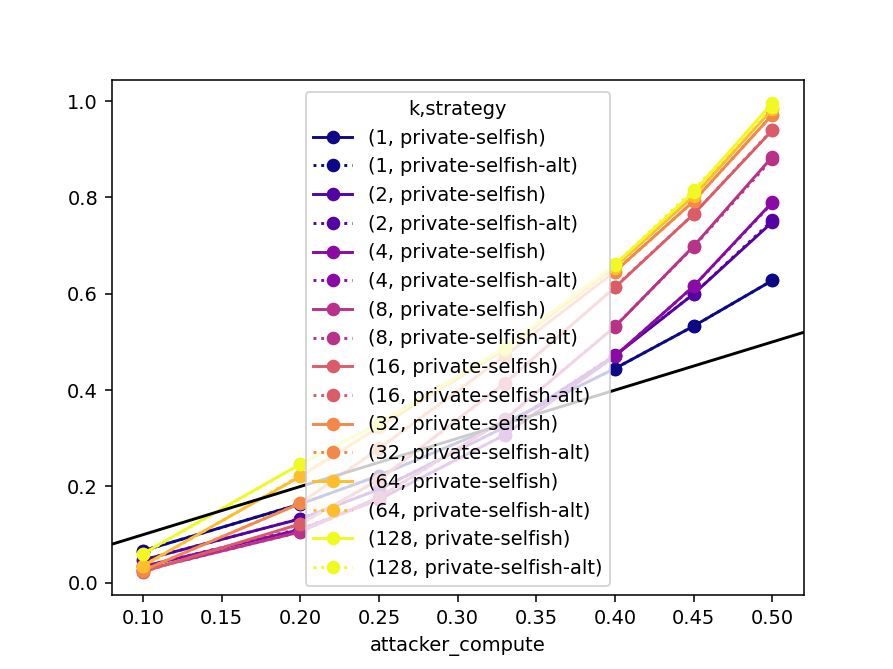

In [12]:
# does numerical implementation line up with non-numerical implementation of policiy?
d = df
d = d[d["protocol"] == "bk"]
d = d[(d["strategy"] == "private-selfish") | (d["strategy"] == "private-selfish-alt")]
d = d[d["incentive_scheme"] == "constant"]
d = d.pivot(
    index=["attacker_compute"],
    columns=["k", "strategy"],
    values="attacker_relative_reward",
)
d = d[sorted(d.columns)]
line_style = ["o-" if proto == "private-selfish" else "o:" for (k, proto) in d.columns]
k = np.unique([k for (k, proto) in d.columns])
cmap = plt.cm.get_cmap("plasma", len(k))
colormap = {k: cmap(i) for (i, k) in enumerate(k)}
line_colors = [colormap[k] for (k, proto) in d.columns]
line_colors
p = d.plot(style=line_style, color=line_colors)
p.axline([0.1, 0.1], [0.5, 0.5], color="black")
# yes it does!